In [161]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
from testWN import testWN as twm
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

In [162]:
%matplotlib notebook

# Get Network Information

In [163]:
inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/felix/.conda/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2085: UserWarning:

Not all curves were used in "../Networks/BWCNdata/c-town_true_network.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [164]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

<IPython.core.display.Javascript object>


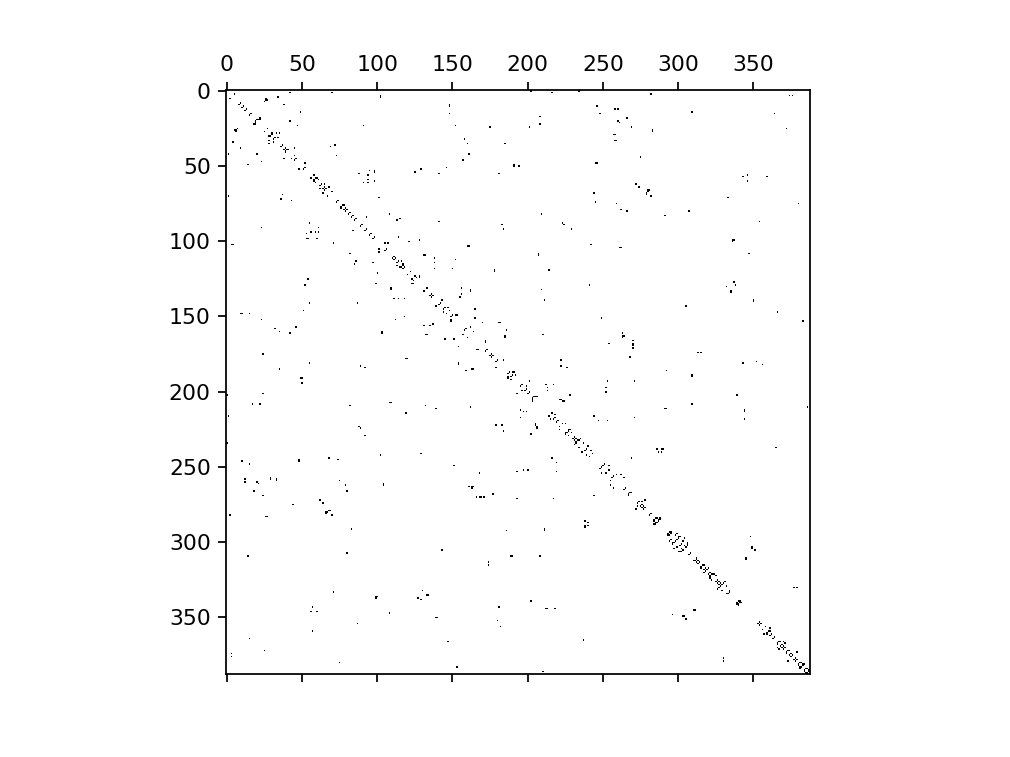

In [165]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [166]:
nodes = ctown.wn.nodes.todict()

In [167]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

## Prepocess Data:

In [168]:
with open('results.pkl', 'rb') as f:
    results=pickle.load(f)

In [169]:
press_junctions =results.node['pressure'][node_names[2]]
junction_coords = coords.loc[node_names[2]]

<IPython.core.display.Javascript object>


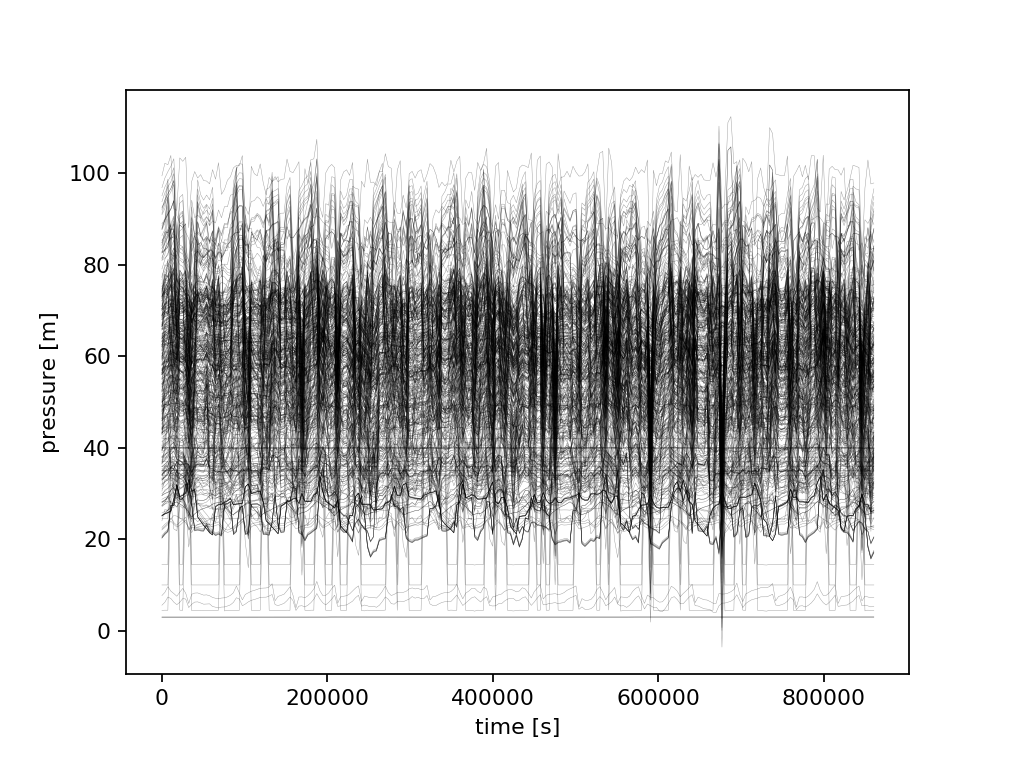

Text(0, 0.5, 'pressure [m]')

In [170]:
fig, ax = plt.subplots()

ax.plot(press_junctions.index, press_junctions, color='k', linewidth=0.2, alpha=.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('pressure [m]')

Normalize Data:

In [171]:
scaling_press = press_junctions.mean()
press_junctions /= scaling_press

Cluster Settings:

In [172]:
n_clusters = 30

## Pressure Clustering

In [173]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(press_junctions.to_numpy())
press_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), columns=node_names[2], index=['pressure'])

In [174]:
press_cluster_labels

,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J299,J300,J301,J302,J304,J306,J307,J309,J317,J323
pressure,10,7,3,2,1,3,16,16,21,21,...,16,16,14,14,11,11,14,14,4,4


<IPython.core.display.Javascript object>


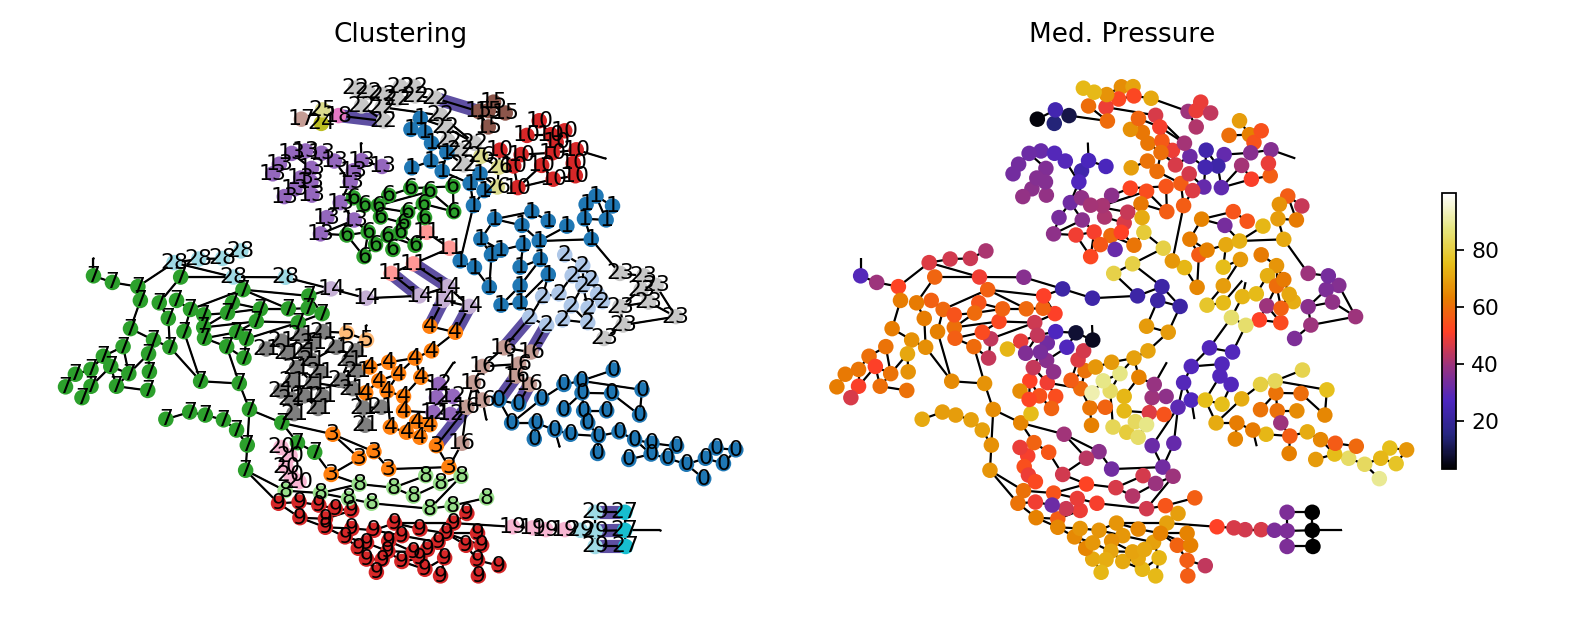

In [175]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.median()

# Highlight pumps
wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Pumps', ax=ax_1[0])
# Highlight valves
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=press_cluster_labels.loc['pressure'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_1[0]) 

wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation

In [176]:
# Calculate cluster mean and standard deviation
jun_cl_press_group = press_junctions.groupby(press_cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

<IPython.core.display.Javascript object>


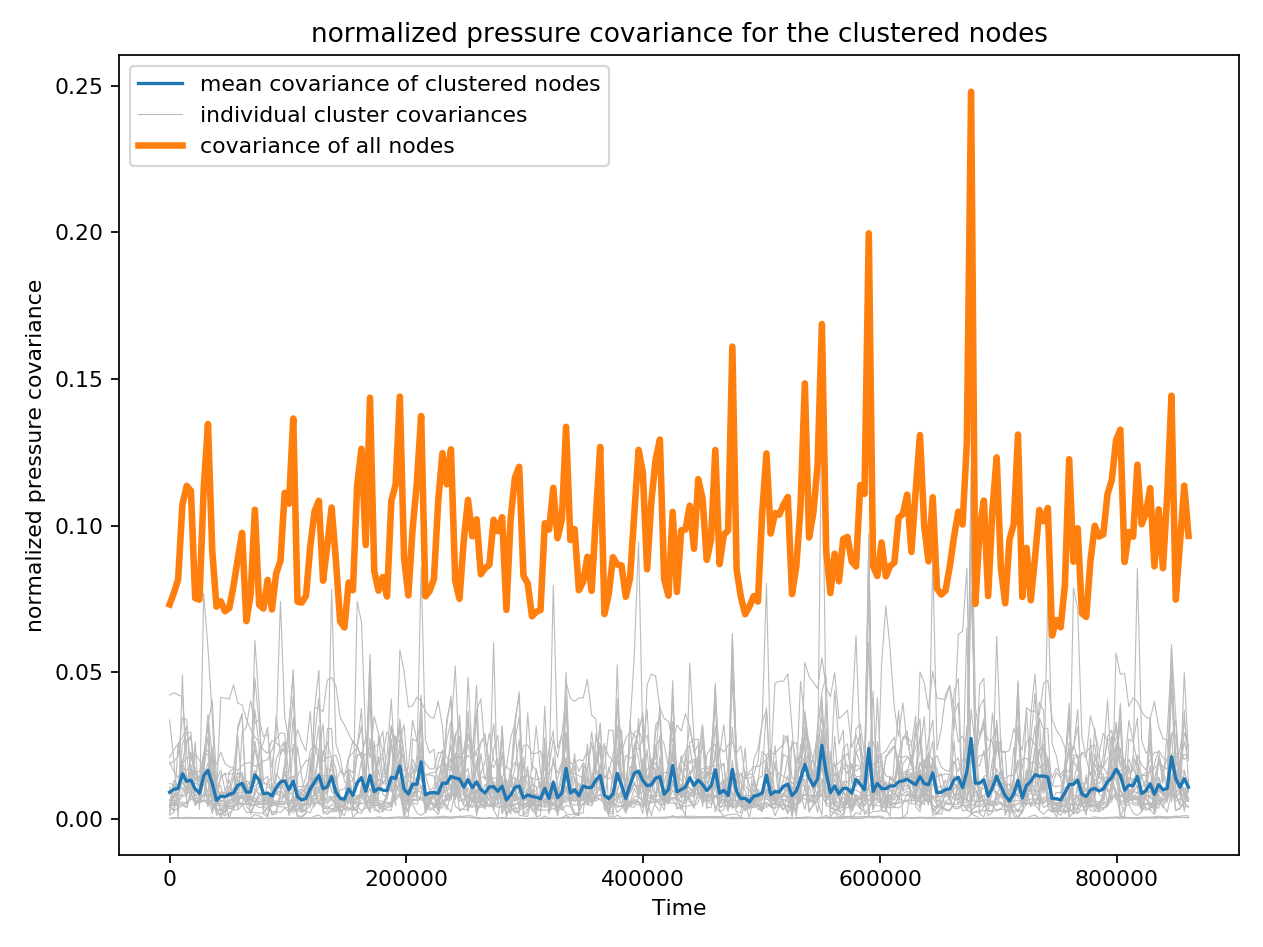

In [177]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_junctions.std(axis=1)
ax_2.plot(press_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

<IPython.core.display.Javascript object>


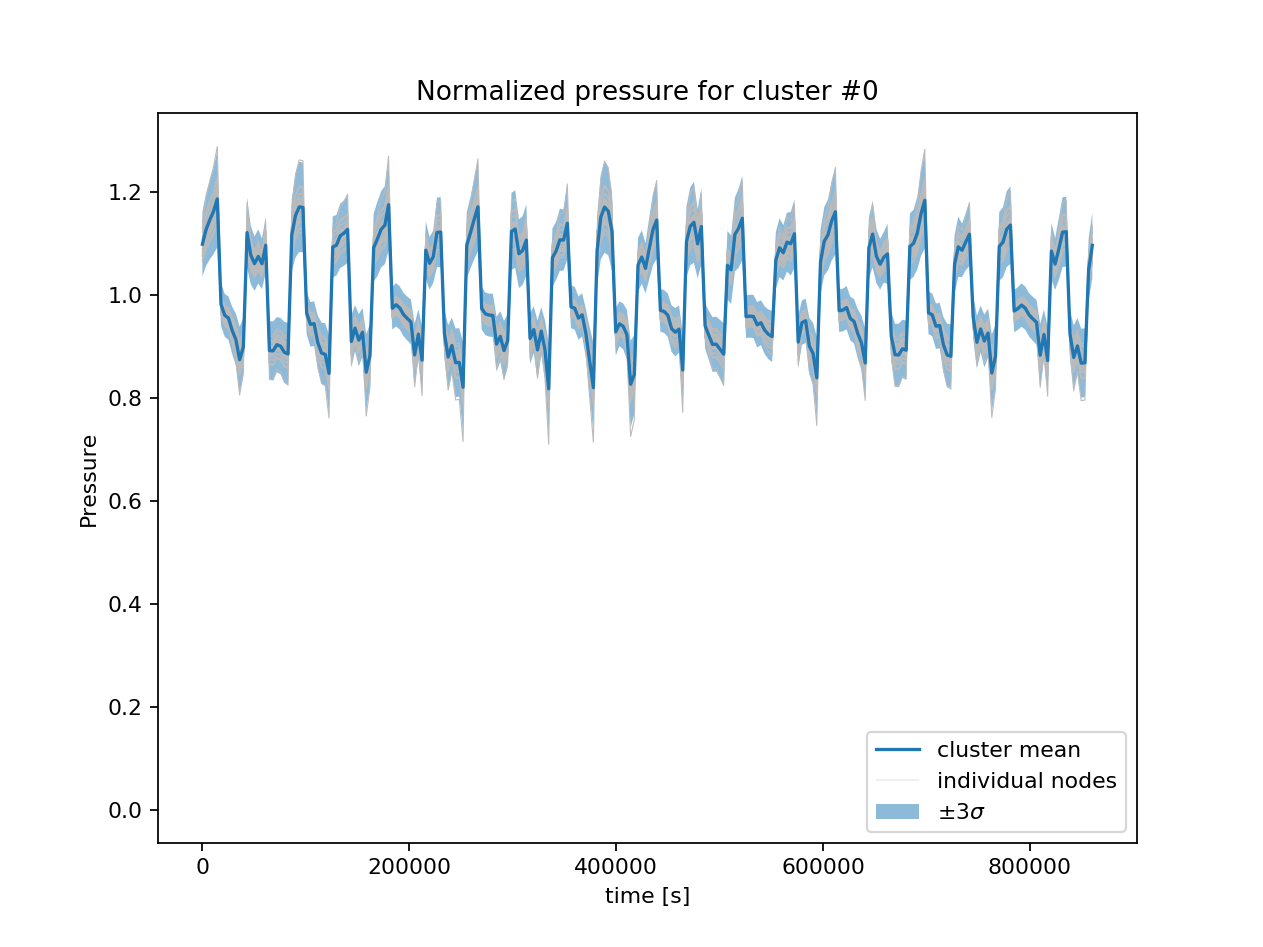

Text(0, 0.5, 'Pressure')

In [200]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=0


ax_2.fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group.get_group(cluster_i), color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.2, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}'.format(cluster_i))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')


## Quality Clustering

In [185]:
qual_junctions = results.node['quality'][node_names[2]]

<IPython.core.display.Javascript object>


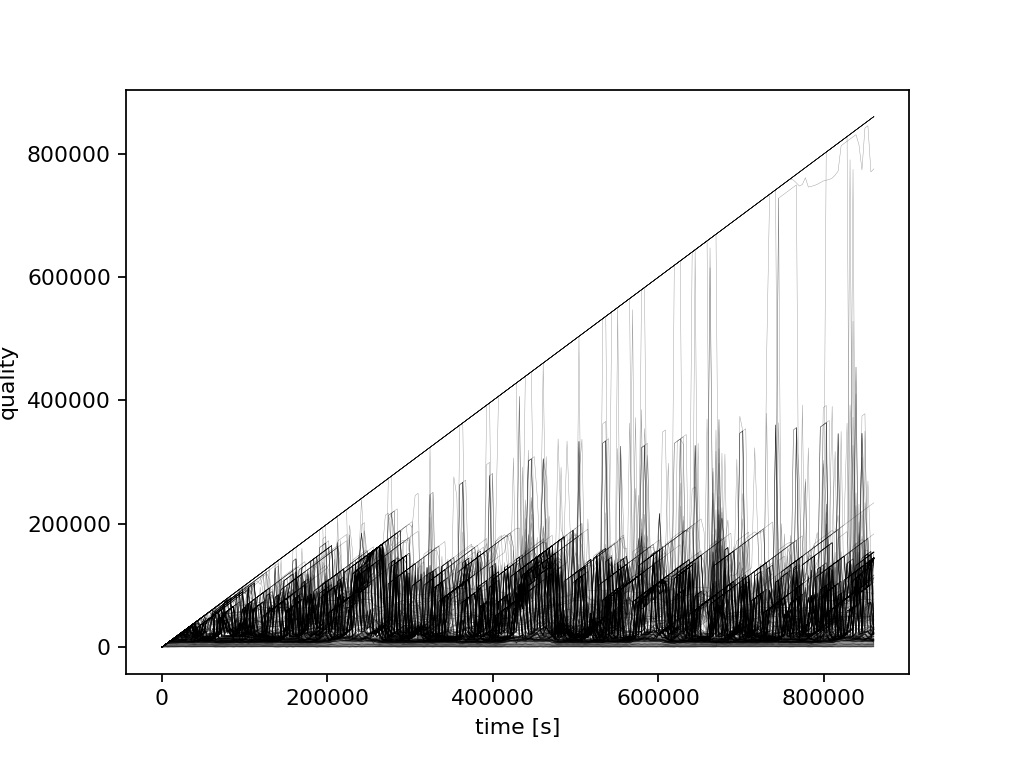

Text(0, 0.5, 'quality')

In [186]:
fig, ax = plt.subplots()

ax.plot(qual_junctions.index, qual_junctions, color='k', linewidth=0.2, alpha=.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('quality')

Normalize Data:

In [187]:
scaling_qual = qual_junctions.mean().mean()
qual_junctions /=  scaling_qual

In [188]:
scaling_qual

61000.676

Cluster Settings:

In [189]:
n_clusters = 30

In [190]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(qual_junctions.to_numpy())

qual_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), 
                                   columns=node_names[2], 
                                   index=['quality'])
cluster_labels = press_cluster_labels.append(qual_cluster_labels)

<IPython.core.display.Javascript object>


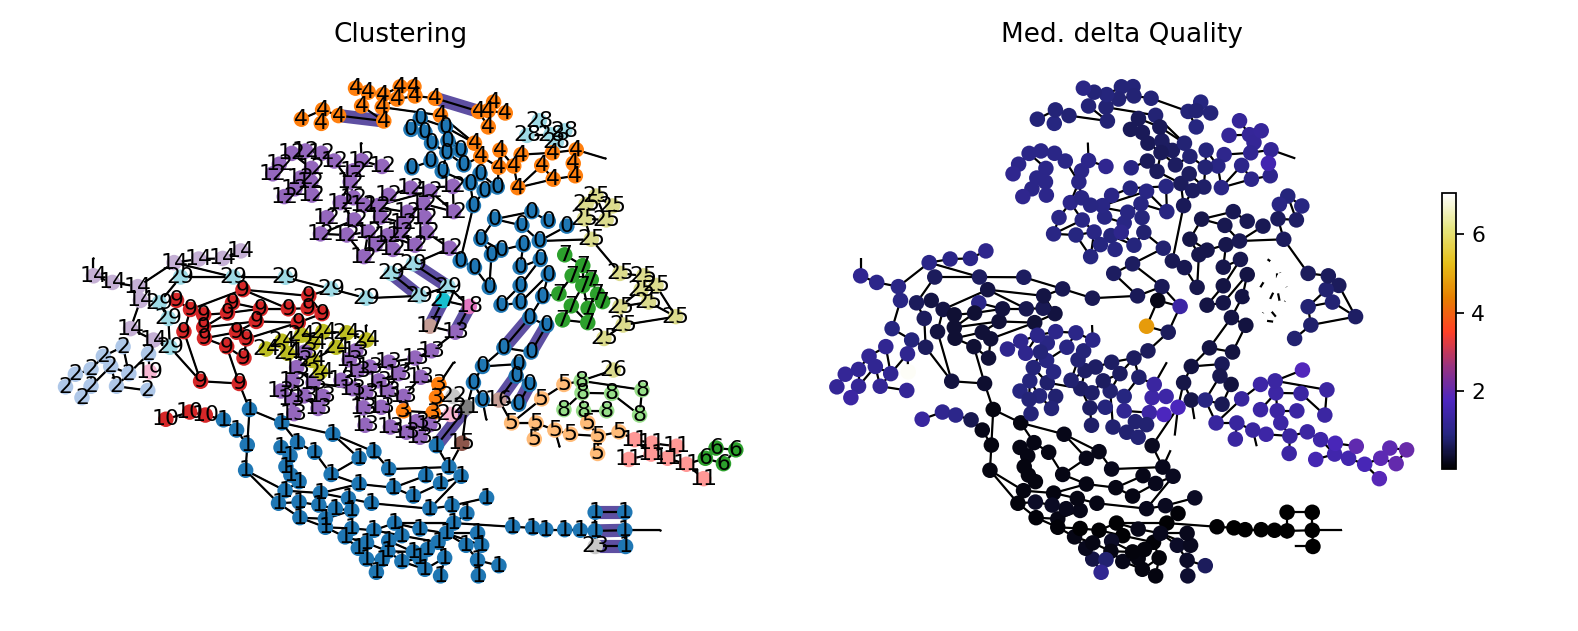

In [191]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
qual_junctions_mean = qual_junctions.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=qual_cluster_labels.loc['quality'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=qual_junctions_mean,node_size=50, 
                           node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

In [192]:
# Calculate cluster mean and standard deviation
jun_cl_qual_group = qual_junctions.groupby(cluster_labels.loc['quality'], axis=1)
jun_cl_qual_mean = jun_cl_qual_group.mean()
jun_cl_qual_std = jun_cl_qual_group.std()

<IPython.core.display.Javascript object>


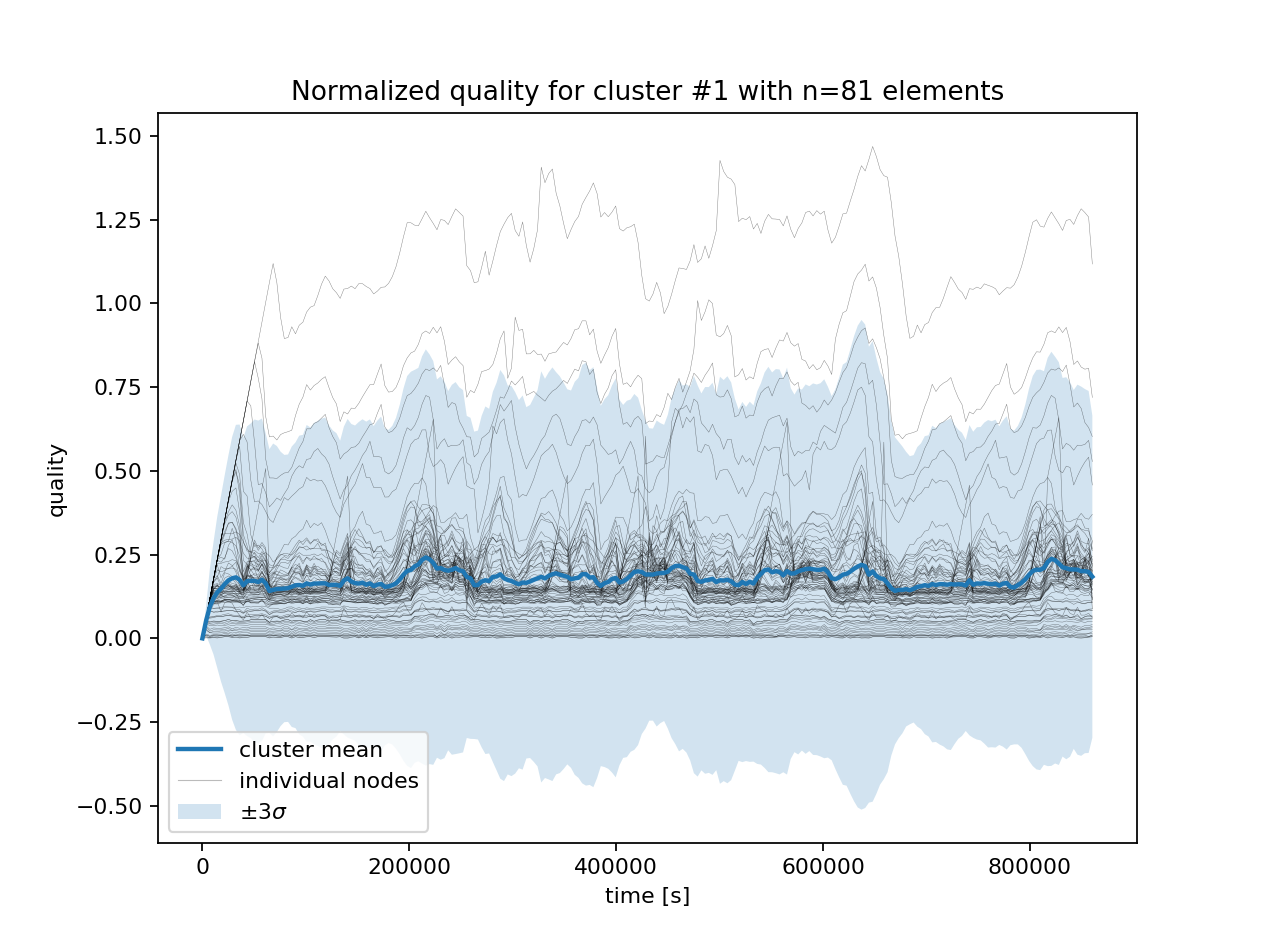

Text(0, 0.5, 'quality')

In [197]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=1

ax_2.fill_between(jun_cl_qual_mean.index,
                  (jun_cl_qual_mean[[cluster_i]]-3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_qual_mean[[cluster_i]]+3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.2, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_qual_group.get_group(cluster_i), color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_qual_mean[[cluster_i]], label='cluster mean', linewidth=2)
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized quality for cluster #{} with n={} elements'.format(cluster_i, jun_cl_qual_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('quality')

<IPython.core.display.Javascript object>


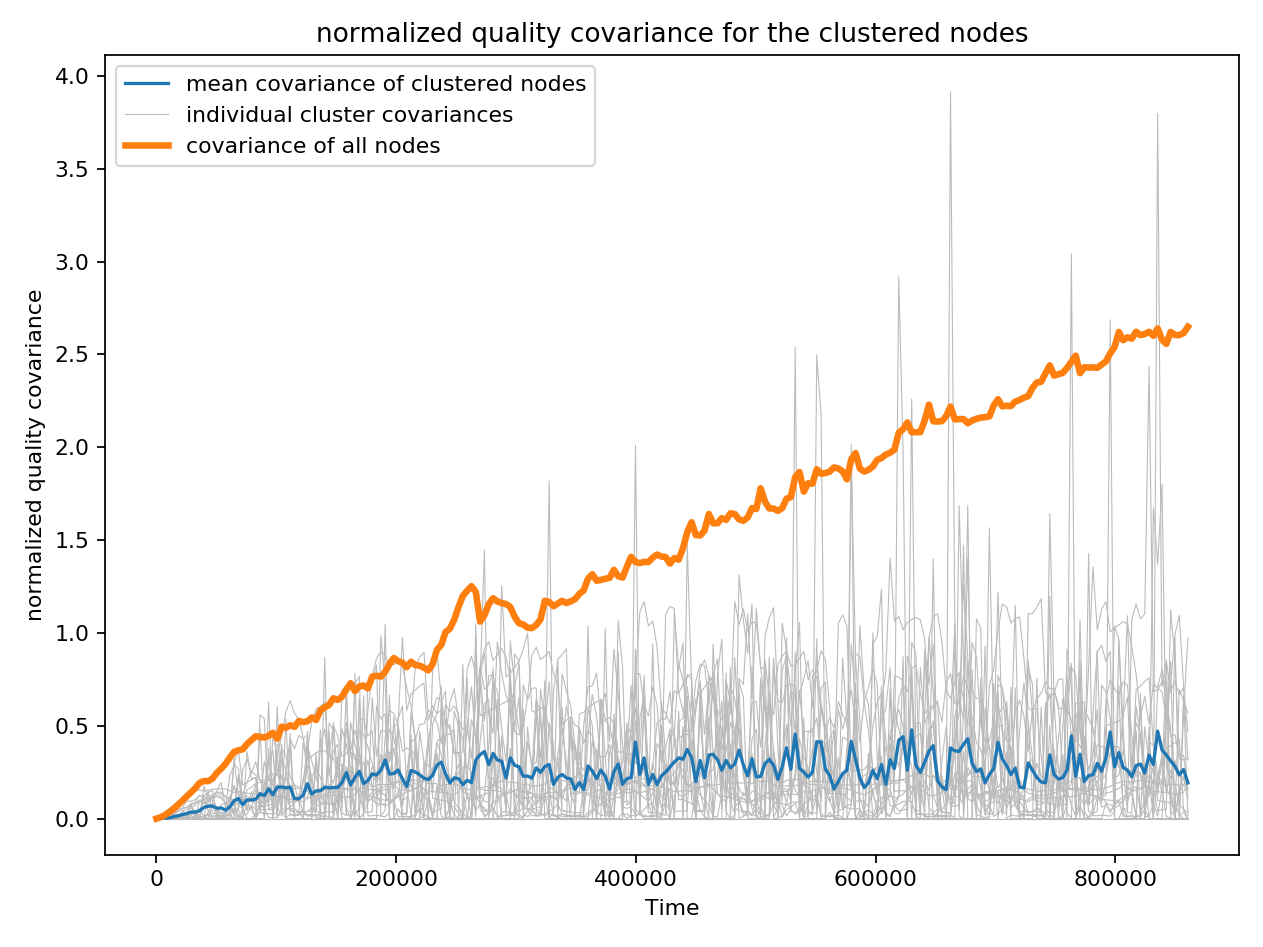

In [194]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_qual_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_qual_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


qual_std_ges = qual_junctions.std(axis=1)
ax_2.plot(qual_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized quality covariance')
ax_2.set_title('normalized quality covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

Export Cluster label

In [363]:
cluster_labels.to_json('./Surrogate_Model/cluster_labels.json')